## 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
from category_encoders import CountEncoder
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,  roc_auc_score

import os
import joblib

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)

random_state = 4012

## 2. Load Data

In [2]:
X_train = pd.read_csv("../Processed Data Files/X_train.csv")
y_train = pd.read_csv("../Processed Data Files/y_train.csv")
X_test = pd.read_csv("../Processed Data Files/X_test.csv")
y_test = pd.read_csv("../Processed Data Files/y_test.csv")

## 3. Model

In [3]:
# Combine them!

scaler = StandardScaler()

onehot = OneHotEncoder(
    categories = [
            ['full time', 'contract', 'part time','flexi','other','unspecified'], # employment_type
            ['entry level', 'middle level', 'senior level', 'unspecified'], # required_experience
            ['high school or vocational degree', 'undergraduate', 'graduate', 'unspecified'], # required_education
    ],
    handle_unknown = 'ignore',  # <- Ignore unknown values (i.e. don't create a column for them)
)

freq_encoder = CountEncoder()

binary_columns = ['telecommuting', 'has_company_logo','has_questions', 'have_company_profile', 'have_requirements', 'have_benefits', 'have_category', 'high_salary']
numerical_columns = ['flesch_score_bin_ft','fk_grade_level_bin_ft', 'text_len']
onehot_columns = ['employment_type', 'required_experience','required_education']
freq_columns = ['location_country']

preprocessor = ColumnTransformer([
    # (nickname, transformer to apply, columns to apply to)
    ('binary', 'passthrough', binary_columns),  # <- 'passthrough' says to keep them but don't apply anything
    ('numerical', scaler, numerical_columns),   
    ('onehot', onehot, onehot_columns),
    ('frequency',freq_encoder, freq_columns),
],  remainder='passthrough')

model = Pipeline(steps=[
    ('preprocess', preprocessor),
    # ('resampling', SMOTEENN(random_state=random_state,enn=EditedNearestNeighbours(sampling_strategy='majority'))),
    ('train', CatBoostClassifier(random_state=random_state)),
])

params = dict(
    train__n_estimators = [100, 200, 300],
    train__learning_rate = [0.1, 0.3, 0.5],
    train__max_depth = [4, 6, 8],
    train__l2_leaf_reg = [1, 5, 10],
    train__border_count = [32, 64, 128],
    train__loss_function = ['Logloss', 'CrossEntropy'],
    train__auto_class_weights = ['Balanced']
)


def train(x_train, y_train, model, params):
    
    gridsearchcv = GridSearchCV(model, params, cv=5, scoring='f1_weighted', verbose=3, n_jobs=-1)
    gridsearchcv.fit(x_train, y_train.values)
    
    best_model = model.set_params(**gridsearchcv.best_params_).fit(x_train, y_train.values)
    

    return best_model, gridsearchcv.best_params_


best_model, best_params = train(X_train, y_train, model, params)

print("Best Parameters:", best_params)

#Best Parameters: {'train__n_estimators': 300, 'train__max_depth': 4, 'train__loss_function': 'Logloss', 'train__learning_rate': 0.1, 'train__l2_leaf_reg': 5, 'train__border_count': 64, 'train__auto_class_weights': 'Balanced'}

Fitting 5 folds for each of 486 candidates, totalling 2430 fits
0:	learn: 0.6198321	total: 174ms	remaining: 52.2s
1:	learn: 0.5526802	total: 193ms	remaining: 28.8s
2:	learn: 0.4982758	total: 212ms	remaining: 21s
3:	learn: 0.4632869	total: 229ms	remaining: 17s
4:	learn: 0.4253447	total: 248ms	remaining: 14.6s
5:	learn: 0.3945607	total: 266ms	remaining: 13s
6:	learn: 0.3754273	total: 284ms	remaining: 11.9s
7:	learn: 0.3625220	total: 301ms	remaining: 11s
8:	learn: 0.3486589	total: 320ms	remaining: 10.4s
9:	learn: 0.3381626	total: 343ms	remaining: 9.95s
10:	learn: 0.3273224	total: 372ms	remaining: 9.77s
11:	learn: 0.3197927	total: 394ms	remaining: 9.45s
12:	learn: 0.3123993	total: 413ms	remaining: 9.11s
13:	learn: 0.3037355	total: 435ms	remaining: 8.88s
14:	learn: 0.2977647	total: 453ms	remaining: 8.6s
15:	learn: 0.2834979	total: 470ms	remaining: 8.34s
16:	learn: 0.2796563	total: 488ms	remaining: 8.13s
17:	learn: 0.2734110	total: 506ms	remaining: 7.93s
18:	learn: 0.2690323	total: 524ms	rem

In [4]:
base_path = "../Models/" # path where the file is going to be saved in 

model_name = 'catboost'

model_path = os.path.join(base_path, f'{model_name}.joblib')

joblib.dump(best_model, model_path)

['../Models/catboost.joblib']

### Feature Importance

In [5]:
catboost_model = best_model.named_steps['train']

feature_importances = catboost_model.get_feature_importance()

def get_feature_names(column_transformer):
    output_features = []

    for name, pipe, features in column_transformer.transformers_:
        if name == 'remainder':
            output_features.extend(features)
        elif isinstance(pipe, OneHotEncoder):
            for feature, categories in zip(features, pipe.categories_):
                output_features.extend([f"{feature}_{category}" for category in categories])
        elif isinstance(pipe, CountEncoder):
            output_features.extend(features)
        else:
            output_features.extend(features)

    return output_features

feature_names = get_feature_names(preprocessor)

In [6]:
if len(feature_importances) == len(feature_names):
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    })

    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    print(importance_df)

                  Feature  Importance
25       location_country    5.724426
10               text_len    4.458953
3    have_company_profile    4.288295
1        has_company_logo    3.162032
4       have_requirements    2.906992
..                    ...         ...
214                   203    0.000000
208                   197    0.000000
385                   374    0.000000
591                   580    0.000000
71                     60    0.000000

[794 rows x 2 columns]


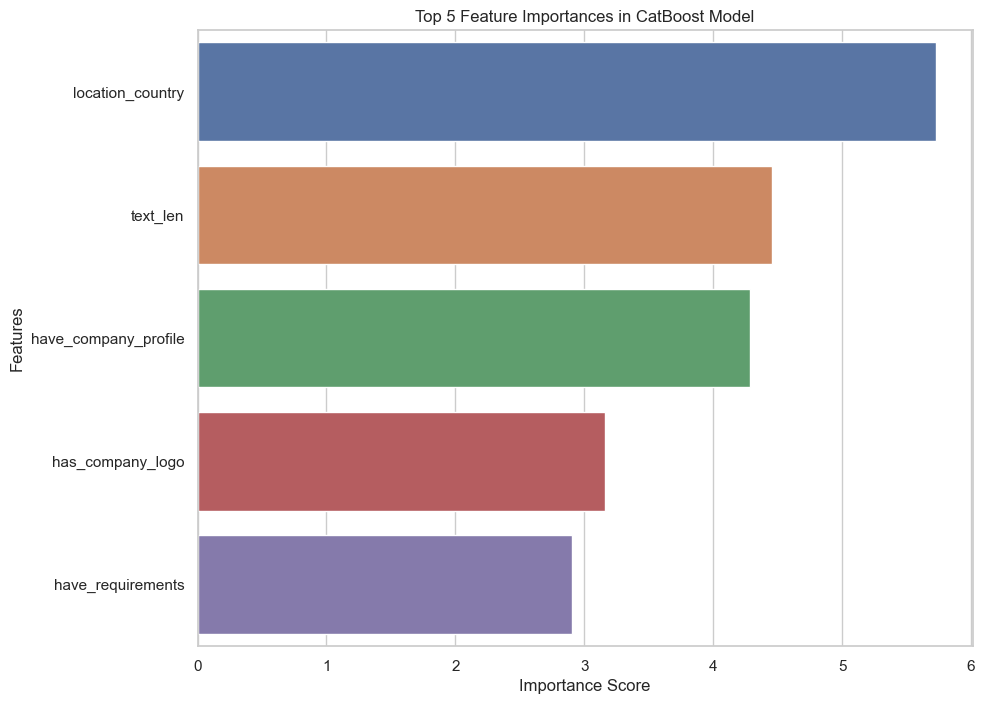

In [7]:
top_features = importance_df.sort_values(by='Importance', ascending=False).head(5)

plt.figure(figsize=(10, 8))
sns.set(style="whitegrid")

sns.barplot(x="Importance", y="Feature", data=top_features)

plt.title('Top 5 Feature Importances in CatBoost Model')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

### LIME

Observation #: 50
Probability(Fraud) = 0.004579149530683159
True class: [0]


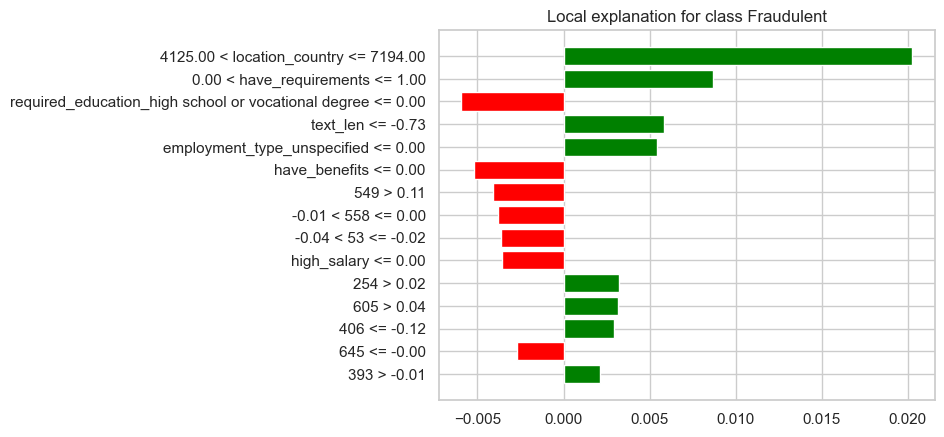

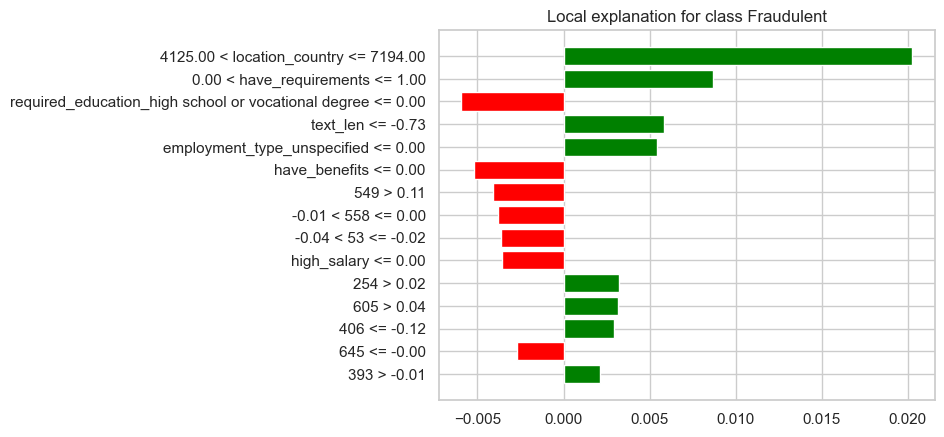

In [9]:
from lime.lime_tabular import LimeTabularExplainer

X_train_transformed = best_model['preprocess'].transform(X_train)

explainer = LimeTabularExplainer(
    training_data=X_train_transformed, 
    feature_names=feature_names, 
    class_names=['Not Fraudulent', 'Fraudulent'],  
    mode='classification'
)

idx = 50
X_test_transformed = best_model['preprocess'].transform(X_test)
data_for_prediction = X_test_transformed[idx]

exp = explainer.explain_instance(
    data_row=data_for_prediction, 
    predict_fn=best_model['train'].predict_proba,
    num_features=15 
)

print('Observation #: %d' % idx)
print('Probability(Fraud) =', best_model['train'].predict_proba(X_test_transformed)[idx][1])
print('True class: %s' % y_test.iloc[idx].values)

exp.as_pyplot_figure()